### Load packages

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from aste_helper_funcs import *

# Read the Grid - do every time

### Define filenames and sizing

In [2]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirRun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirDiags = dirRun + "diags/"
dirState = dirDiags + "STATE/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [3]:
bigaste = True    # set up something to trigger in case we run with either big or little

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

### Define the Grid

In [4]:
mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','DXG','DYG'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    print(temp.shape)
    print(temp.reshape(nz, ny, nx).shape)
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

(50, 4050, 90)
(50, 1350, 270)


In [5]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)
# hf1 = hf1[np.newaxis,:, :]
hf1.shape

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

hf1 (1350, 270)
SZ! (1, 900, 540)
shape of fld: (1, 900, 540)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270) (1, 1350, 270)


In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

# 3d
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023
RAC2d (146614,)


In [7]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

# Make the DataSet

### Create a mask of the wet points for the rest of the data - compact shape

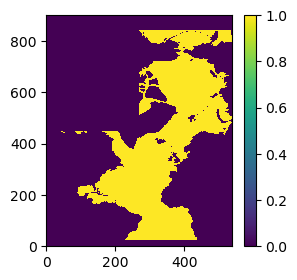

In [8]:
wetmask = np.zeros((ny*nx))
wetmask[iwetC2d[np.where(hf2d>0)[0]]] = 1
wetmask =  np.reshape(wetmask,(ny,nx))
wetmaskplt = get_aste_tracer(wetmask,nfx,nfy)
# wetmaskplt = wetmaskplt.reshape(nfy[0]+nx+nfx[3],2*nx)
wetmaskplt = wetmaskplt.reshape(wetmaskplt.shape[1],wetmaskplt.shape[2])
plt.figure(figsize=(3,3))
plt.pcolormesh(wetmaskplt)
plt.colorbar()

### Read in the file - create xr

In [9]:
# I think one file is __ time
fileTS = rdmds(dirState + "/state_3d_set1",4464)
fldListTS = parsemeta(dirState + "state_3d_set1.0000004464.meta")["fldList"]
print(fldListTS)
fileTS = fileTS.reshape(2,nz, ny, nx)
fileTS.shape  # compact form

['THETA', 'SALT']


(2, 50, 1350, 270)

In [10]:
# we want to mask our values with nan based on the wet points first- this will help with binning
wetmask[wetmask == 0] = np.nan

In [11]:
# remember that in order to plot this we have to use get_aste_tracer on the 1350 x 270 array
# this will give us the array that we can plot

In [12]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'T data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'S data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'ppt'}

In [13]:
temp = xr.DataArray(data = fileTS[0,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = fileTS[1,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [14]:
ds = xr.Dataset({'theta': temp, 'salinity': salt})

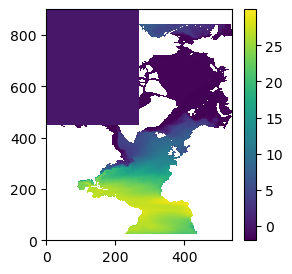

In [15]:
# test plot to make sure we are doing this correctly
fig = plt.figure(figsize=(3,3))
plt.pcolormesh(get_aste_tracer(temp[0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Grab the TS bins

In [16]:
# let's create a binning function with numpy
def bin_array(arr, bin_edges):
    flattened_arr = arr.flatten()
    bin_indices = np.digitize(flattened_arr, bin_edges)
    bin_indices_3d = bin_indices.reshape(arr.shape)
    
    return bin_indices_3d-1

In [17]:
# let's do a tester to make sure this function works - if these are the bin edges left and right inclusive, we would want to subtract 1
# ie if there are 10 bin edges, there are 9 bins, we want i-1
bins = np.arange(-1,10,1)
print(bins)
vals = np.array([0,0.3,.4,-0.2,3.3,3.8,2,8.9])
bin_array(vals,bins)

[-1  0  1  2  3  4  5  6  7  8  9]


array([1, 1, 1, 0, 4, 4, 3, 9])

In [18]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
# print(np.nanmin(binned_theta),np.nanmin(ds.theta.values),binsTH_edges[int(np.nanmin(binned_theta))])
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan        # not sure about this one
# print(np.nanmin(binned_salinity),np.nanmin(ds.salinity.values),binsSLT_edges[int(np.nanmin(binned_salinity))])

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [19]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

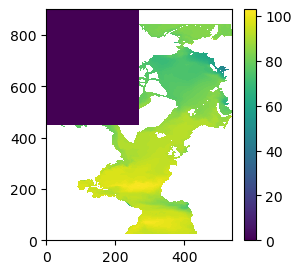

In [20]:
fig = plt.figure(figsize=(3,3))


plt.pcolormesh(get_aste_tracer(ds["salinity_binned"][0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Great, now we binned the values. Can we get the volume per cell?

In [21]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1,1)
dS = dS.reshape(112,112,1,1)

In [22]:
# the volume will just be based on the grid cell in the model
# we need the actual distance width, height, and depth of the model cells
# ALL IN COMPACT FORM, NEED get_aste_tracer(_, nfx,nfy) to plot
dxg = mygrid["DXG"]      # length on southern edge
dyg = mygrid["DYG"]     # length on eastern edge
depth = mygrid['Depth']    # compact form
hFacC = mygrid['hFacC']
drf = mygrid['DRF']        # depth between faces of cells

# reshape before multiplication
drf_expanded = drf[:,np.newaxis,np.newaxis]
cell_area = dxg*dyg

print(cell_area[np.newaxis,:,:].shape,drf_expanded.shape,hFacC.shape,dT.shape,dS.shape)   # check shapes

ffac=1e-6
cell_volume = cell_area[np.newaxis,:,:] * drf_expanded * hFacC * ffac    # width * heigh * area * fraction * ffac
print(cell_volume.shape)
print(binned_salt.shape,binned_temp.shape)

(1, 1350, 270) (50, 1, 1) (50, 1350, 270) (112, 112, 1, 1) (112, 112, 1, 1)
(50, 1350, 270)
(50, 1350, 270) (50, 1350, 270)


In [23]:
wetmask = wetmask.reshape(1350,270)
wetmask[np.newaxis,:,:].shape

(1, 1350, 270)

In [24]:
cell_volume = cell_volume * wetmask[np.newaxis,:,:]

In [25]:
binned_salt = binned_salt * wetmask[np.newaxis,:,:]
binned_temp = binned_temp*wetmask[np.newaxis,:,:]

In [26]:
import time

In [27]:
testertemp = ds.theta.values
testersalt = ds.salinity.values

In [28]:
# Initialize mesh
starttime = time.time()

mesh = np.zeros((nS, nT, ny, nx))   # binsTH_edges-1

# Generate indices for valid wet points
valid_indices = np.where(~np.isnan(wetmask))


# # Iterate over all points in the domain
for i in range(ny):
    if i%250 == 0:
        print(i,"in",time.time()-starttime)
    for j in range(nx):
        if not np.isnan(wetmask[i, j]):
            # Get the column of interest
            thiscol = cell_volume[:, i, j]
            thissalt = binned_salt[:, i, j].values
            thistemp = binned_temp[:, i, j].values

            # add testers to see if indexing is the issue
            testertempcol = testertemp[:,i,j]
            testersaltcol = testersalt[:,i,j]

            # There was something funky going on with non-nan values, let's loop and be slow
            for k in range(thiscol.shape[0]):
                if not np.isnan(thissalt[k]) and not np.isnan(thistemp[k]):
                    # Accumulate values into mesh using advanced indexing
                    #print(int(thistemp[k]), int(thissalt[k]),binsTH_edges[int(thistemp[k])], binsSLT_edges[int(thissalt[k])],testertempcol[k],testersaltcol[k])
                    mesh[int(thissalt[k]), int(thistemp[k]),i, j] += thiscol[k]

mesh /= dT
mesh /= dS

0 in 0.0027234554290771484
250 in 14.262196779251099
500 in 30.71364736557007
750 in 55.30021071434021
1000 in 62.532859325408936
1250 in 69.02627658843994


In [29]:
# add the mesh to the dataset
dims = ("i_Tbins","i_Sbins","compact_x","compact_y")
# not sure if we want the bin centers I think so 
coords = {"i_Tbins" : np.arange(0,nT,1),
          "i_Sbins" : np.arange(0,nS,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrs = {'title' : 'binned volume data within T and S bins for whole ASTE',
         'standard_name' : 'binnev volume',
         'units' : 'm^3/(deg C PSU)'}

In [30]:
# syntax
mesh2 = xr.DataArray(data = mesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrs)

In [31]:
ds["volume_mesh"] = mesh2

In [32]:
ds

<xarray.Dataset>
Dimensions:          (z: 50, compact_x: 1350, compact_y: 270, i_Tbins: 112,
                      i_Sbins: 112)
Coordinates:
  * z                (z) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * compact_x        (compact_x) int64 0 1 2 3 4 5 ... 1345 1346 1347 1348 1349
  * compact_y        (compact_y) int64 0 1 2 3 4 5 6 ... 264 265 266 267 268 269
  * i_Tbins          (i_Tbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
  * i_Sbins          (i_Sbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
Data variables:
    theta            (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity         (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    theta_binned     (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity_binned  (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    volume_mesh      (i_Tbins, i_Sbins, compact_x, compact_y) float64 0.0 ......

### example plotting for whole area

In [ ]:
# iall = np.where((ds["mskBasin"].values >= 0) & (ds["mskBasin"].values <= 14))
iall = np.where(ds["mskBasin"].values == 0)
iall[0].shape
ycoords = iall[0]
xcoords = iall[1]

In [ ]:
test = ds['volume_mesh'].values

In [ ]:
# testall = np.nansum(ds['volume_mesh'].values[:,:,ycoords[:100],xcoords[:100]],axis=(2))
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [ ]:
cmap = plt.get_cmap('viridis').copy()
# cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

In [ ]:
binned_theta.shape

In [ ]:
np.nansum(test[:,:,25,40])

### Load the basins

In [33]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

In [34]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_xr = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsWet)

ds['mskBasin'] = mskBasin_xr
ds['wetmask'] = wetmask_xr

In [35]:
ds

<xarray.Dataset>
Dimensions:          (z: 50, compact_x: 1350, compact_y: 270, i_Tbins: 112,
                      i_Sbins: 112)
Coordinates:
  * z                (z) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * compact_x        (compact_x) int64 0 1 2 3 4 5 ... 1345 1346 1347 1348 1349
  * compact_y        (compact_y) int64 0 1 2 3 4 5 6 ... 264 265 266 267 268 269
  * i_Tbins          (i_Tbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
  * i_Sbins          (i_Sbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
Data variables:
    theta            (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity         (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    theta_binned     (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    salinity_binned  (z, compact_x, compact_y) float64 nan nan nan ... nan nan
    volume_mesh      (i_Tbins, i_Sbins, compact_x, compact_y) float64 0.0 ......
    mskBasin         (compact_x, compact_y) float64 nan nan nan ... nan nan nan
    wetmask          (compact_x, compact_y) float64 nan nan nan ... nan nan nan

In [49]:
path = "/home/mmurakami/crios_backups/ASTE_270"
ds.to_netcdf(path + '/example.nc')

# Skip here if DataSet already made

In [ ]:
ds = xr.load_dataset("../example.nc")

In [ ]:
ds

### Plot for a specific Basin - ie BarentsS

In [37]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = mpl.cm.get_cmap("viridis",14).copy()
cmap = truncate_colormap(cmap, 0.15)
cmap.set_under(color='white')

/tmp/ipykernel_529353/3075689644.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("viridis",14).copy()


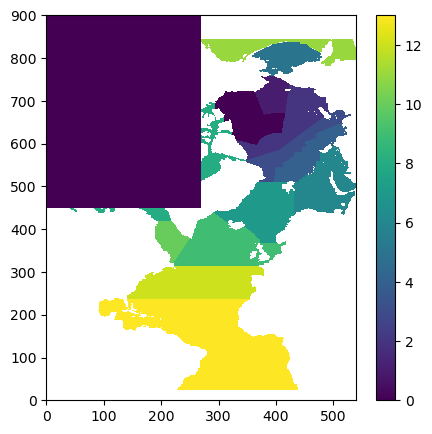

In [38]:
plt.figure(figsize = (5,5))
plt.pcolormesh(get_aste_tracer(ds["mskBasin"].values,nfx,nfy)[0])
plt.colorbar(cmap = cmap)

In [39]:
iBarents = np.where(ds["mskBasin"].values == 6)  # this has been checked to see same values as in lookat_layers
iBarents

(array([434, 434, 434, ..., 561, 561, 561]),
 array([162, 163, 246, ...,  51,  52,  53]))

In [40]:
testBarents = np.nansum(ds['volume_mesh'].values[:,:,iBarents[0],iBarents[1]],axis=2)

In [41]:
testBarents.shape

(112, 112)

In [42]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

/tmp/ipykernel_529353/4127153003.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(Sbin,Tbin,np.log10(testBarents))


(-2.5, 7.5)

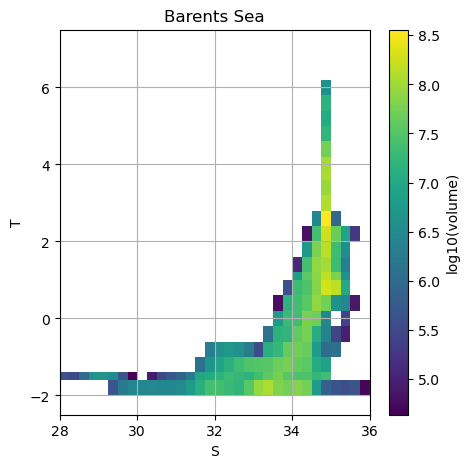

In [48]:
plt.figure(figsize = (5,5))
plt.pcolormesh(Sbin,Tbin,np.log10(testBarents))
plt.colorbar(label="log10(volume)")
plt.title("Barents Sea")
plt.xlabel("S")
plt.ylabel("T")
plt.grid()
plt.xlim(28,36)
plt.ylim(-2.5,7.5)